## Análisis de sentimientos
##### RunnableLambda y chains

Arquitsectura del analizador de sentimientos

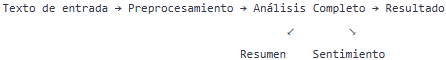

In [31]:
import os
from dotenv import load_dotenv

load_dotenv()

if os.getenv("OPENAI_API_KEY"):
    print("cargado correctamente")

cargado correctamente


In [32]:
from langchain_core.runnables import RunnableLambda, RunnableParallel
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [33]:
#Preprocesador de texto
def preprocesar_text(text):
    """Limpia el texto eliminando extras y limitando longitud"""
    return text.strip()[:500]

preprocessor = RunnableLambda(preprocesar_text)

In [34]:
#Generar Resumen
def generate_summary(text):
    """Genera un resumen conciso del texto"""
    prompt = f"Resume en pocas palabras: {text}"
    response = llm.invoke(prompt)
    return response.content

summary_branch = RunnableLambda(generate_summary)

In [35]:
#Análisis de sentimientos en formato Json
import json
def analyze_sentiment(text):
    "Analiza el sentimiento y devuelvve en formato estructurado"
    prompt = f"""Analiza el sentimiento del siguiente texto. Responde ÚNICAMENTE en formato JSON válido: {{"sentimiento":"positivo|negativo|neutro","razon":"justificacion breve}}
    Texto: {text}"""
    response = llm.invoke(prompt)
    try:
        return json.loads(response.content)
    except json.JSONDecodeError:
        return {"sentimiento": "neutro", "razon":"Error al analizar"}

sentimient_branch = RunnableLambda(analyze_sentiment)

In [36]:
#Combinacion de resultados
def merge_results(data):
    """Combina los resultados de ambas ramas en un formato unificado"""
    return {
        "resumen": data["resumen"],
        "sentimiento": data["sentimiento_data"]["sentimiento"],
        "razon": data["sentimiento_data"]["razon"]
    }

merge = RunnableLambda(merge_results)

In [37]:
#Ejecuta las funciones en paralelo
parallel_analysis = RunnableParallel({
    "resumen":summary_branch,
    "sentimiento_data":sentimient_branch
})

In [38]:
#chain
chain = preprocessor | parallel_analysis | merge
chain.invoke("Hola necesito que me revise mi internet, esta superlento no tengo serviso 8 dias, ayuda")

{'resumen': 'El usuario solicita ayuda para revisar su conexión a internet, ya que está muy lenta y no tiene servicio desde hace 8 días.',
 'sentimiento': 'negativo',
 'razon': 'El texto expresa frustración y una necesidad urgente de asistencia debido a un problema con el servicio de internet.'}

In [39]:
#reviews
review_batch = [
    "Excelente producto, muy satisfecho con la compra",
    "Terrible calidad, no lo recomiendo  para nada",
    "Esta bien, su fución básica pero nada especial"
]

#Procesamiento de entrada por lotes - batch se utiliza a cambio de invoke
resultado = chain.batch(review_batch)
resultado

[{'resumen': 'Producto excelente, muy satisfecho con la compra.',
  'sentimiento': 'positivo',
  'razon': 'El texto expresa satisfacción y aprecio por el producto adquirido.'},
 {'resumen': 'Mala calidad, no lo recomiendo.',
  'sentimiento': 'negativo',
  'razon': 'El texto expresa descontento y una recomendación negativa sobre la calidad del producto.'},
 {'resumen': 'Es funcional, pero no destaca por nada en particular.',
  'sentimiento': 'neutro',
  'razon': 'El texto expresa una opinión que reconoce la funcionalidad básica, pero también indica que no hay nada destacable o especial, lo que sugiere una falta de entusiasmo.'}]

Aqui se pensaba ejecutar en serie (chain) pero se puede ejecutar en paralelo con la funcion RunnableParallel

Conclusion: Al ejecutar en paralelo se disminuye el tiempo de ejecucion, se puede decir que en paralelo es mas rápido

In [40]:
# def procces_one(t):
#     resumen = generate_summary(t)
#     sentimiento_data = analyze_sentiment(t)
#     return merge_results(resumen,sentimiento_data)

# process = RunnableLambda(procces_one)